In [20]:
import sklearn
import tensorflow as tf
from tensorflow import keras
from matplotlib import pylab as plt
# import matplotlib #don't delete!

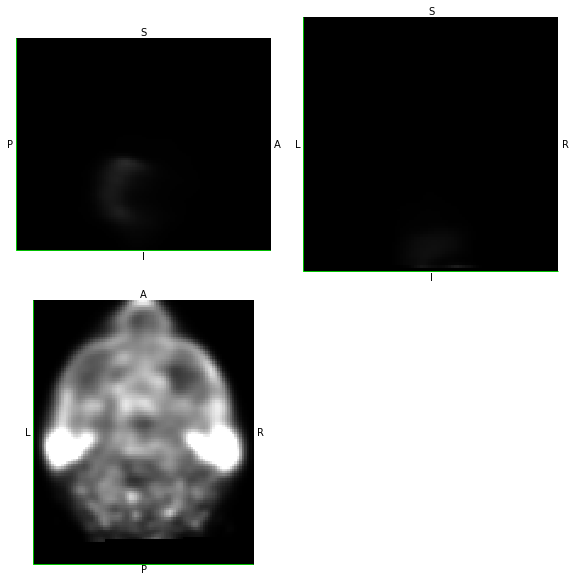

(91, 109, 91)

In [21]:
from matplotlib import pylab as plt
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
example_filename = "./datasets/A4/A4_aligned/B10018169/Florbetapir/cmeanA4_B10018169_MR_Florbetapir_Br_20200720182306561_S893044_I1321166.nii.gz"
 
img = nib.load(example_filename)
OrthoSlicer3D(img.dataobj).show()
fdata=img.get_fdata()
fdata.shape

In [22]:
import pandas as pd
import nibabel as nib
import os,warnings
warnings.filterwarnings('error')

df=pd.read_csv("datasets/A4/document/A4_PETVADATA_PRV2.csv")
normalize=lambda x:(x-x.mean())/x.std()
unusable=[]
x,y=[],[]
maxnum=-1
for i,(bid,score) in enumerate(zip(df.BID,df.SCORE)):
    if i==maxnum:break
    try:
        dirname="datasets/A4/A4_aligned/{}/Florbetapir/".format(bid)
        filelist=os.listdir(dirname)
        filename=None
        # print(filelist)
        # input()
        for t_fname in filelist:
            if not '(' in t_fname: filename=t_fname
        # filename=filelist[0]
        if filename is None:
            raise "BID_{}:file not found!".format(bid)
        ngz=nib.load(os.path.join(dirname,filename))
        x.append(normalize(ngz.get_fdata()))
        y.append(score)
    
    except Exception as e:
        unusable.append(bid)
        print(e)
        # print("BID_{} unusable.".format(id))
dataset=(x,y)
print(unusable)

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
[Errno 2] No such file or directory: 'datasets/A4/A4_aligned/B38895224/Florbetapir/'
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value

In [23]:
### data augmentation & preprocessing
from tensorflow.keras import Sequential,layers
#augmentation (don't do like this!)
data_augmentation=Sequential([
    # layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.05),
])
#preprocess(wrong code)
data_preprocess=Sequential([
    layers.BatchNormalization(),# not bn in training
    # layers.experimental.preprocessing.Resizing()
])

In [24]:
from sklearn.model_selection import train_test_split,KFold
x_train,x_test,y_train,y_test=train_test_split(
    dataset[0],dataset[1],test_size=0.1,random_state=1919810
)
kf = KFold(n_splits=10)

In [25]:
import scipy
import numpy as np
# data_preprocess(x_train,y_train)
def ndresize(x):
    orisize=np.array(x.shape)
    tgsize=np.array((42,50,42))
    return scipy.ndimage.zoom(x,tgsize/orisize,order=1)

def random_padcut3d(x,rate):
    # dim=len(x.shape)
    pc=(x.shape*np.random.uniform(-rate/2.,rate/2.,size=(3))).astype(np.int32)
    pad=np.maximum(0,pc)
    # pad=np.max(np.array((0),dtype=np.int32),pc)
    cut=np.minimum(0,pc)
    cut=tuple([slice(None,None) if c==0 else slice(-c,c) for c in cut])
    
    x=np.pad(x,((pad[0],pad[0]),(pad[1],pad[1]),(pad[2],pad[2])))
    x=x[cut]
    # len(x.shape)
    # dtlist=[np.pad]
    return x
def train_preprocess(x,y,agrate=5):
    try:
        x=np.array(x)
        x=normalize(x)
        xlist=[]
        for i in range(agrate):
            x=random_padcut3d(x,0.15)
            x=ndresize(x)
            xlist.append(x)
        x=xlist
        y=[0 if y[0]=="n"else 1]*agrate
        return x,y
    except Exception as w:
        print(w)
        return [],[]

def test_preprocess(x,y):
    try:
        x=np.array(x)
        x=normalize(x)
        xlist=[]
        x=ndresize(x)
        xlist.append(x)
        x=xlist
        y=[0 if y[0]=="n"else 1]
        return x,y
    except Exception as w:
        print(w)
        return [],[]

In [26]:
import time
from tqdm import tqdm

# td=np.array([train_preprocess(x,y)
x_trainp,y_trainp=[],[]
for x,y in tqdm(zip(x_train,y_train)):
    agx,agy=train_preprocess(x,y)
    x_trainp+=agx
    y_trainp+=agy
x_trainp,y_trainp=np.array(x_trainp),np.array(y_trainp)
# td=np.array(sum(,start=[]))
# x_trainp,y_trainp=td[:,0],td[:1]
# print(x_trainp)

3983it [02:37, 25.26it/s]


In [27]:
from tensorflow.keras import callbacks
from units.model import CNN3D

cb = [
    callbacks.ModelCheckpoint(
        filepath="checkpoints/ckpt-loss={loss:.2f}", save_freq=10000
    )
]
model=CNN3D()
model.fit(x_trainp,y_trainp,64,epochs=30,callbacks=cb,validation_split=0.05)
model.save("./models/m{}.h5".format(time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())))
model.save("./models/latest.h5")

Epoch 1/30
296/296 [==============================] - 22s 72ms/step - loss: 0.6415 - sparse_categorical_accuracy: 0.6424 - val_loss: 0.6299 - val_sparse_categorical_accuracy: 0.6908
Epoch 2/30
296/296 [==============================] - 20s 69ms/step - loss: 0.6011 - sparse_categorical_accuracy: 0.6988 - val_loss: 0.5929 - val_sparse_categorical_accuracy: 0.6837
Epoch 3/30
296/296 [==============================] - 21s 70ms/step - loss: 0.5841 - sparse_categorical_accuracy: 0.7066 - val_loss: 0.5754 - val_sparse_categorical_accuracy: 0.6908
Epoch 4/30
296/296 [==============================] - 20s 68ms/step - loss: 0.5696 - sparse_categorical_accuracy: 0.7135 - val_loss: 0.5592 - val_sparse_categorical_accuracy: 0.6948
Epoch 5/30
296/296 [==============================] - 20s 68ms/step - loss: 0.5580 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.5430 - val_sparse_categorical_accuracy: 0.7159
Epoch 6/30
296/296 [==============================] - 20s 69ms/step - loss: 0.5421 - spars

In [ ]:
### advanced learn
from tensorflow.keras.models import load_model
model=load_model("./models/latest.h5")
model.fit(x_trainp,y_trainp,64,epochs=30,callbacks=cb,validation_split=0.05)
model.save("./models/m{}.h5".format(time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())))
model.save("./models/latest.h5")

Epoch 1/30
34/34 [==============================] - 3s 75ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.6947 - val_loss: 0.6363 - val_sparse_categorical_accuracy: 0.7768
Epoch 2/30
34/34 [==============================] - 2s 67ms/step - loss: 0.6228 - sparse_categorical_accuracy: 0.6933 - val_loss: 0.6275 - val_sparse_categorical_accuracy: 0.7768
Epoch 3/30
34/34 [==============================] - 2s 68ms/step - loss: 0.6208 - sparse_categorical_accuracy: 0.6971 - val_loss: 0.6186 - val_sparse_categorical_accuracy: 0.7768
Epoch 4/30
34/34 [==============================] - 2s 69ms/step - loss: 0.6275 - sparse_categorical_accuracy: 0.6971 - val_loss: 0.6087 - val_sparse_categorical_accuracy: 0.7768
Epoch 5/30
34/34 [==============================] - 2s 68ms/step - loss: 0.6184 - sparse_categorical_accuracy: 0.6962 - val_loss: 0.5989 - val_sparse_categorical_accuracy: 0.7768
Epoch 6/30
34/34 [==============================] - 2s 68ms/step - loss: 0.6211 - sparse_categorical_accu

KeyboardInterrupt: 

In [ ]:
x_testp,y_testp=[],[]
for x,y in tqdm(zip(x_test,y_test)):
    agx,agy=test_preprocess(x,y)
    x_testp+=agx
    y_testp+=agy
x_testp,y_testp=np.array(x_testp),np.array(y_testp)

50it [00:00, 55.10it/s]


In [ ]:
from tensorflow.keras import metrics
y_predit=model.predict(x_testp)
tot=metrics.sparse_categorical_accuracy(y_testp,y_predit)
acc=sum(tot)/len(tot)
print("Test accuracy={}".format(acc.numpy()))

Test accuracy=0.7799999713897705


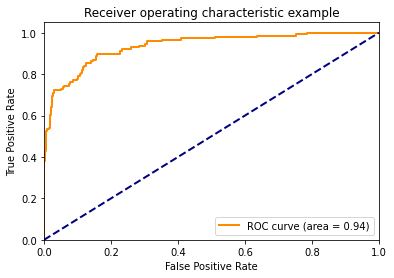

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
# from scipy import interp


# ylabel=label_binarize(y_testp,classes=[0,1])
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(2):
fpr, tpr, _ = roc_curve(y_testp, y_predit[:, 1])
roc_auc = auc(fpr, tpr)
# fpr[0].shape==tpr[0].shape==(21, ), fpr[1].shape==tpr[1].shape==(35, ), fpr[2].shape==tpr[2].shape==(33, ) 
# roc_auc {0: 0.9118165784832452, 1: 0.6029629629629629, 2: 0.7859477124183007}

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.title('ROC of Score')
plt.legend(loc="lower right")
plt.show()
